Because the meaning of the "tracheo" column is of outstanding importance in all models, we examine the model performance in this notebook without this column. We want to check whether the meaning of the other features changes.

**Imports and Settings**

In [1]:
# basic modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score 
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier

#settings
warnings.filterwarnings('ignore')
rs = 42
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
c = StratifiedKFold(n_splits=3)

# Dictionary for overview
models = {}

In [2]:
# Dataframe with engineered features (for further information notebook 06_Feature_engineering)
df = pd.read_csv('./data/mimic_premodel_advanced.csv')

In [3]:
# remove the column tracheo
df = df.drop(labels='tracheo', axis=1)

In [4]:
df.head()

,label,hadm_id,icustay_id,age,numb_diagn,PaO2,base_excess,creatinin,hb,pH,...,median_SaO2,std_SaO2,skew_SaO2,kurto_SaO2,minimum_leuko,maximum_leuko,median_leuko,std_leuko,skew_leuko,kurto_leuko
0,1.0,100017.0,258320.0,28.0,8.0,171.0,4.0,0.8,14.3,7.52,...,100.0,0.000000,0.000000,0.000000,9.3,9.3,9.30,1.284338,0.282498,0.424949
1,1.0,100035.0,245719.0,37.0,26.0,39.0,10.0,1.1,14.0,7.41,...,96.0,1.778516,0.104363,-0.201570,17.2,17.2,17.20,1.284338,0.282498,0.424949
2,1.0,100063.0,241782.0,46.0,11.0,365.0,2.0,1.0,14.0,7.39,...,100.0,0.421637,-1.778781,1.406250,8.4,8.4,8.40,1.284338,0.282498,0.424949
3,1.0,100087.0,294404.0,57.0,18.0,143.0,5.0,0.7,15.2,7.47,...,97.0,1.262354,0.717665,0.180998,8.5,8.7,8.60,0.141421,0.282498,0.424949
4,1.0,100141.0,243747.0,40.0,10.0,62.0,6.0,0.8,7.6,7.48,...,95.0,1.414791,0.514331,1.590646,4.9,5.8,5.35,0.636396,0.282498,0.424949


# Scaling and Train/Test-Split

We don't use the IDs (hadm_id, icustay_id) for the training.

In [5]:
X = df.iloc[:, 3:]
y = df.label

In [6]:
X.head()

,age,numb_diagn,PaO2,base_excess,creatinin,hb,pH,FiO2,PEEP,SaO2,...,median_SaO2,std_SaO2,skew_SaO2,kurto_SaO2,minimum_leuko,maximum_leuko,median_leuko,std_leuko,skew_leuko,kurto_leuko
0,28.0,8.0,171.0,4.0,0.8,14.3,7.52,40.000001,5.0,100.0,...,100.0,0.000000,0.000000,0.000000,9.3,9.3,9.30,1.284338,0.282498,0.424949
1,37.0,26.0,39.0,10.0,1.1,14.0,7.41,70.000000,5.0,95.0,...,96.0,1.778516,0.104363,-0.201570,17.2,17.2,17.20,1.284338,0.282498,0.424949
2,46.0,11.0,365.0,2.0,1.0,14.0,7.39,50.000000,0.0,100.0,...,100.0,0.421637,-1.778781,1.406250,8.4,8.4,8.40,1.284338,0.282498,0.424949
3,57.0,18.0,143.0,5.0,0.7,15.2,7.47,30.000000,5.0,97.0,...,97.0,1.262354,0.717665,0.180998,8.5,8.7,8.60,0.141421,0.282498,0.424949
4,40.0,10.0,62.0,6.0,0.8,7.6,7.48,50.000000,2.0,95.0,...,95.0,1.414791,0.514331,1.590646,4.9,5.8,5.35,0.636396,0.282498,0.424949


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 4068 samples.
Testing set has 1357 samples.


In [8]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Functions

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Logistic Regression

## Hyperparameter by default

In [10]:
lr = LogisticRegression(random_state=rs)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [11]:
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.57      0.21      0.31       442
         1.0       0.71      0.92      0.80       915

    accuracy                           0.69      1357
   macro avg       0.64      0.57      0.55      1357
weighted avg       0.66      0.69      0.64      1357

F-Beta-Score(0.5) =  0.74


Confusion matrix, without normalization
[[ 93 349]
 [ 70 845]]


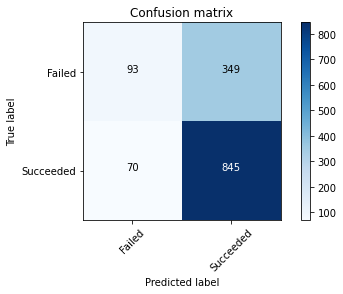

In [12]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

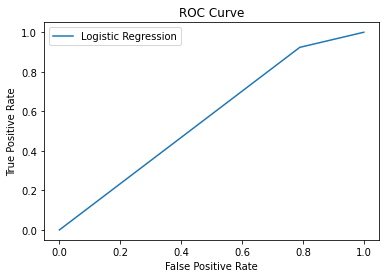

AUC(logReg)= 0.67


In [13]:
# Plot the ROC curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_prob = lr.predict_proba(X_test)
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")

In [14]:
models['logReg_simple'] = [precision_score(y_test, y_pred_lr),
                    fbeta_score(y_test, y_pred_lr, beta=0.5),
                    roc_auc_score(y_test, y_pred_lr_prob[:,1]),
                    accuracy_score(y_test, y_pred_lr)]

## Hyperparameter tuning

In [15]:
# Hyperparameter grid for RandomSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [100, 10, 1, 0.1, 0.01] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = fhalf_scorer, cv = c, 
                        n_iter = 100, verbose = 1, random_state=rs)

# Fit 
lr_rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.0s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LogisticRegression(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none']},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=1)

In [16]:
lr_rs.best_params_

{'penalty': 'none', 'C': 100}

In [17]:
# Hyperparameter grid for GridSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [3, 2, 1 , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_gs = GridSearchCV(estimator, param_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
lr_gs.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    1.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2,
                               0.1, 0.09, 0.08, 0.07, 0.06],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [18]:
lr_gs.best_params_

{'C': 3, 'penalty': 'none'}

In [19]:
best_model_lr_gs = lr_gs.best_estimator_

In [20]:
y_pred_lr_best = best_model_lr_gs.predict(X_test)
print(classification_report(y_test, y_pred_lr_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.58      0.21      0.31       442
         1.0       0.71      0.92      0.80       915

    accuracy                           0.69      1357
   macro avg       0.64      0.57      0.56      1357
weighted avg       0.67      0.69      0.64      1357

F-Beta-Score(0.5) =  0.74


Confusion matrix, without normalization
[[ 94 348]
 [ 69 846]]


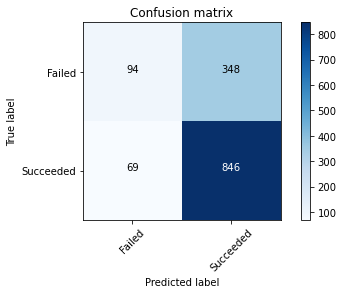

In [21]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

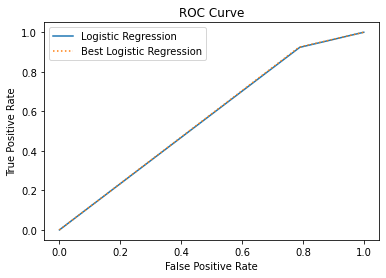

AUC(logReg)= 0.67
AUC(BestlogReg)= 0.67


In [22]:
# Plot the ROC curve
fpr_lr_best, tpr_lr_best, thresholds_lr_best = roc_curve(y_test, y_pred_lr_best)
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.plot(fpr_lr_best, tpr_lr_best, linestyle=':', label='Best Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_best_prob = best_model_lr_gs.predict_proba(X_test)
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")
print(f"AUC(BestlogReg)= {roc_auc_score(y_test, y_pred_lr_best_prob[:,1]):.2f}")

In [23]:
models['logReg_best'] = [precision_score(y_test, y_pred_lr_best),
                    fbeta_score(y_test, y_pred_lr_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_lr_best_prob[:,1]),
                    accuracy_score(y_test, y_pred_lr_best)]

# Random Forest

##  Advanced Model

In [24]:
rf_clf_base = RandomForestClassifier(random_state=rs)
rf_clf_base.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
y_pred_rf_clf_base = rf_clf_base.predict(X_test)

### Evaluate Advanced Model

In [26]:
print(classification_report(y_test, y_pred_rf_clf_base))
print(confusion_matrix(y_test, y_pred_rf_clf_base))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_clf_base, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.65      0.16      0.26       442
         1.0       0.70      0.96      0.81       915

    accuracy                           0.70      1357
   macro avg       0.68      0.56      0.54      1357
weighted avg       0.69      0.70      0.63      1357

[[ 72 370]
 [ 39 876]]
F-Beta-Score(0.5) =  0.74


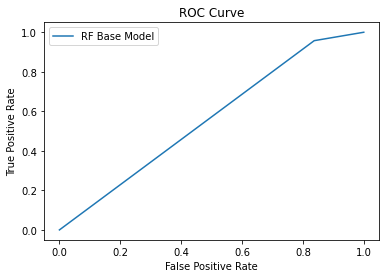

AUC(BaseModel)= 0.67


In [27]:
# ROC Curve Base Model and Dummy
fpr_rf_bm, tpr_rf_bm, thresholds_rf_bm = roc_curve(y_test, y_pred_rf_clf_base)
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_clf_base = rf_clf_base.predict_proba(X_test)
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")

In [28]:
models['RF_simple'] = [precision_score(y_test, y_pred_rf_clf_base),
                    fbeta_score(y_test, y_pred_rf_clf_base, beta=0.5),
                    roc_auc_score(y_test, y_proba_rf_clf_base[:,1]),
                    accuracy_score(y_test, y_pred_rf_clf_base)]

In [29]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_clf_base.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## Random Search

In [30]:
# Set scorer for random search to f-beta 0.5
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
# set cross-validation to a stratified split of 3
c_strat=StratifiedKFold(n_splits=3)

In [31]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [32]:
# Random search of parameters, using 3 fold cross validation 
rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, scoring=fhalf_scorer, 
                               n_iter = 100, cv = c_strat, random_state=rs, n_jobs = -1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5))

In [33]:
rf_random.best_params_

{'n_estimators': 1788,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

## Grid Search

In [34]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [20, 30, 40],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [500, 1000, 1500]
}

In [35]:
# Instantiate the grid search model
grid_search_rf_adv = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, scoring=fhalf_scorer, 
                           cv = c_strat, n_jobs = -1)

# Fit the grid search to the data
grid_search_rf_adv.fit(X_train, y_train)

# Y Predict
y_pred_rf_adv = grid_search_rf_adv.predict(X_test)

In [36]:
grid_search_rf_adv.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 500}

In [37]:
best_model_rf_adv = grid_search_rf_adv.best_estimator_

### Evaluate Grid Search

In [38]:
print(classification_report(y_test, y_pred_rf_adv))
print(confusion_matrix(y_test, y_pred_rf_adv))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_adv, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.74      0.19      0.31       442
         1.0       0.71      0.97      0.82       915

    accuracy                           0.71      1357
   macro avg       0.73      0.58      0.56      1357
weighted avg       0.72      0.71      0.65      1357

[[ 85 357]
 [ 30 885]]
F-Beta-Score(0.5) =  0.75


Confusion matrix, without normalization
[[ 85 357]
 [ 30 885]]


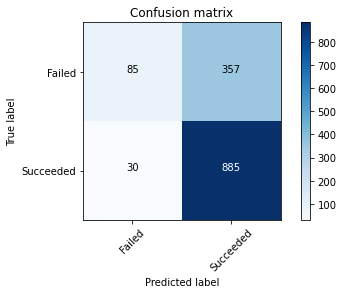

In [39]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rf_adv)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

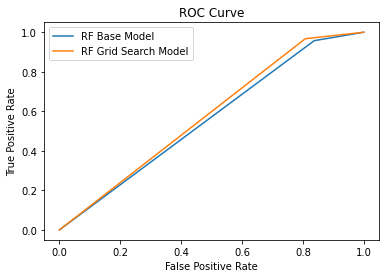

AUC(BaseModel)= 0.67
AUC(GridSearch)= 0.68


In [40]:
# ROC Curve Random Search Model, Base Model and Dummy
fpr_rf_gs, tpr_rf_gs, thresholds_rf_gs = roc_curve(y_test, y_pred_rf_adv)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.plot(fpr_rf_gs, tpr_rf_gs, linestyle='-', label='RF Grid Search Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_adv = best_model_rf_adv.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")
print(f"AUC(GridSearch)= {roc_auc_score(y_test, y_proba_rf_adv[:,1]):.2f}")

In [41]:
models['RF_best'] = [precision_score(y_test, y_pred_rf_adv),
                    fbeta_score(y_test, y_pred_rf_adv, beta=0.5),
                    roc_auc_score(y_test, y_proba_rf_adv[:,1]),
                    accuracy_score(y_test, y_pred_rf_adv)]

# AdaBoost

In [42]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

         0.0       0.59      0.28      0.38       442
         1.0       0.72      0.91      0.80       915

    accuracy                           0.70      1357
   macro avg       0.66      0.59      0.59      1357
weighted avg       0.68      0.70      0.66      1357



In [43]:
fbeta_score(y_test, y_pred_ada, beta=0.5)

0.7524932003626473

Text(0.5, 1.0, 'Confusion matrix')

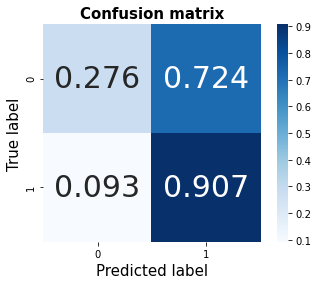

In [44]:
cm = confusion_matrix(y_test, ada.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

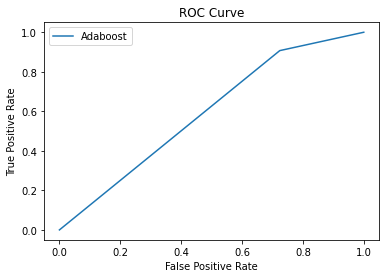

AUC(Adaboost)= 0.66


In [45]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

In [46]:
models['Ada_simple'] = [precision_score(y_test, y_pred_ada),
                    fbeta_score(y_test, y_pred_ada, beta=0.5),
                    roc_auc_score(y_test, y_pred_ada_prob[:,1]),
                    accuracy_score(y_test, y_pred_ada)]

## Randomsearch

In [47]:
ada_grid = dict()
ada_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
ada_grid['n_estimators'] = [100, 200, 250, 300, 500]

model = AdaBoostClassifier()
grid = ada_grid
    
# run randomized search and optimize for fhalf_scorer
ada_rdm = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs, cv=c)
search = ada_rdm.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.3min finished


In [48]:
print(search.best_params_)

{'n_estimators': 300, 'learning_rate': 0.1}


In [49]:
y_pred_ada_rdm = ada_rdm.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred_ada_rdm))

              precision    recall  f1-score   support

         0.0       0.74      0.20      0.32       442
         1.0       0.71      0.97      0.82       915

    accuracy                           0.72      1357
   macro avg       0.73      0.58      0.57      1357
weighted avg       0.72      0.72      0.66      1357



In [51]:
fbeta_score(y_test, y_pred_ada_rdm, beta=0.5)

0.753880266075388

Text(0.5, 1.0, 'Confusion matrix')

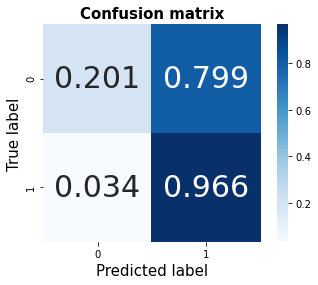

In [52]:
cm = confusion_matrix(y_test, ada_rdm.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

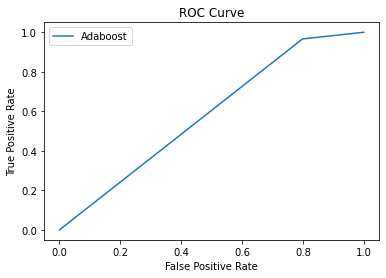

AUC(Adaboost)= 0.69


In [53]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada_rdm)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_rdm.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

## Gridsearch

In [54]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

# TODO: Initialize the classifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[200],                
              'learning_rate':[0.1, 0.08, 0.12,],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# TODO: Make an fbeta_score scoring object
scorer = fhalf_scorer

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(ada, parameters,scorer, cv=c) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_ada = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (ada.fit(X_train, y_train)).predict(X_test)
best_predictions = best_ada.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_ada)


Unoptimized model
------
Accuracy score on testing data: 0.5917
F-score on testing data: 0.6957

Optimized Model
------
Final accuracy score on the testing data: 0.7126
Final F-score on the testing data: 0.7511
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=200)


In [55]:
ada_grid = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.4, n_estimators=250)
ada_grid.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.4, n_estimators=250)

In [56]:
y_pred_ada_grid = ada_grid.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred_ada_grid))

              precision    recall  f1-score   support

         0.0       0.66      0.27      0.38       442
         1.0       0.73      0.93      0.82       915

    accuracy                           0.72      1357
   macro avg       0.69      0.60      0.60      1357
weighted avg       0.70      0.72      0.68      1357



In [58]:
fbeta_score(y_test, y_pred_ada_grid, beta=0.5)

0.7592229549099981

Text(0.5, 1.0, 'Confusion matrix')

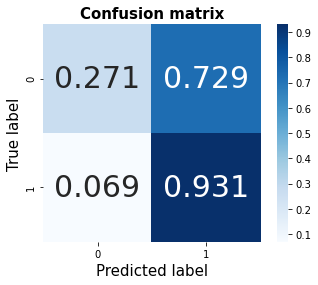

In [59]:
cm = confusion_matrix(y_test, ada_grid.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

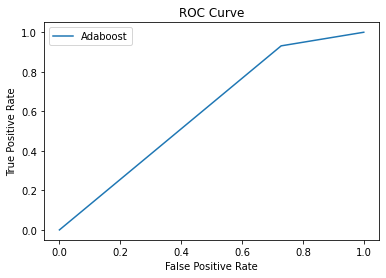

AUC(Adaboost)= 0.67


In [60]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred_ada_grid)
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_grid.predict_proba(X_test)
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

In [61]:
models['Ada_best'] = [precision_score(y_test, y_pred_ada_grid),
                    fbeta_score(y_test, y_pred_ada_grid, beta=0.5),
                    roc_auc_score(y_test, y_pred_ada_prob[:,1]),
                    accuracy_score(y_test, y_pred_ada_grid)]

# XGBoost

In [62]:
# instanciate classifier, fit model
xgboost = XGBClassifier(random_state=rs)
xgboost.fit(X_train, y_train)

XGBClassifier(random_state=42)

In [63]:
y_pred_xgb = xgboost.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.70      0.23      0.34       442
         1.0       0.72      0.95      0.82       915

    accuracy                           0.72      1357
   macro avg       0.71      0.59      0.58      1357
weighted avg       0.71      0.72      0.66      1357



In [65]:
fbeta_score(y_test, y_pred_xgb, beta=0.5)

0.7558441558441558

Text(0.5, 1.0, 'Confusion matrix')

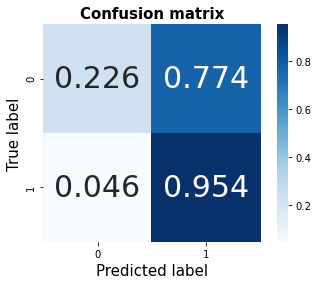

In [66]:
cm = confusion_matrix(y_test, xgboost.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

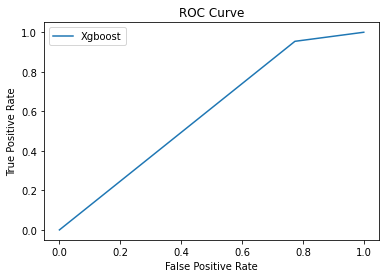

AUC(Xgboost)= 0.69


In [67]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = xgboost.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

In [68]:
models['XGB_simple'] = [precision_score(y_test, y_pred_xgb),
                    fbeta_score(y_test, y_pred_xgb, beta=0.5),
                    roc_auc_score(y_test, y_pred_xgb_prob[:,1]),
                    accuracy_score(y_test, y_pred_xgb)]

## random search

In [69]:
xgb_grid = dict()
xgb_grid['max_depth'] = [2, 3, 4, 5, 6]
xgb_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
xgb_grid['gamma'] = [0,0.1,0.2,0.3,0.4,0.5]

model = XGBClassifier()
grid = xgb_grid
    
# run randomized search and optimize for fhalf_scorer
clf = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs,cv=c)
search = clf.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   41.5s finished


In [70]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.70      0.21      0.32       442
         1.0       0.71      0.96      0.82       915

    accuracy                           0.71      1357
   macro avg       0.71      0.58      0.57      1357
weighted avg       0.71      0.71      0.66      1357



In [71]:
print(search.best_params_)

{'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}


best result: {'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3}

In [72]:
y_pred_xgb_rdm = clf.predict(X_test)

In [73]:
fbeta_score(y_test, y_pred_xgb_rdm, beta=0.5)

0.7527066506272556

Text(0.5, 1.0, 'Confusion matrix')

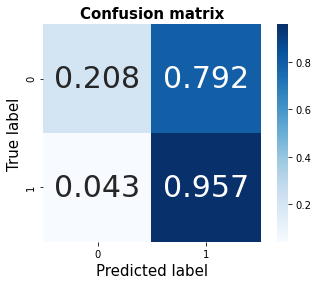

In [74]:
cm = confusion_matrix(y_test, clf.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

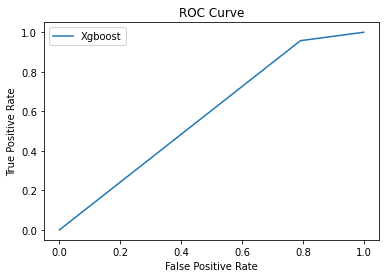

AUC(Xgboost)= 0.68


In [75]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_lr = roc_curve(y_test, y_pred_xgb_rdm)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = clf.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

## Gridsearch

In [76]:
param_grid = {
    'max_depth': [2,3,4],
    'learning_rate': [0.02, 0.01],
    'gamma': [0.3, 0.35, 0.25],}

optimal_params = GridSearchCV(
    estimator= XGBClassifier(), cv=c,
    param_grid=param_grid,
     scoring = fhalf_scorer)## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 3}


{'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 4}

In [77]:
y_pred_xgb_grid = optimal_params.predict(X_test)

In [78]:
print(classification_report(y_test, y_pred_xgb_grid))

              precision    recall  f1-score   support

         0.0       0.70      0.21      0.32       442
         1.0       0.71      0.96      0.82       915

    accuracy                           0.71      1357
   macro avg       0.71      0.58      0.57      1357
weighted avg       0.71      0.71      0.66      1357



In [79]:
fbeta_score(y_test, y_pred_xgb_grid, beta=0.5)

0.7527066506272556

Text(0.5, 1.0, 'Confusion matrix')

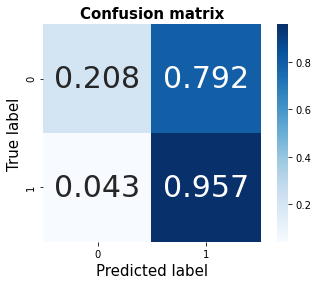

In [80]:
cm = confusion_matrix(y_test, optimal_params.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

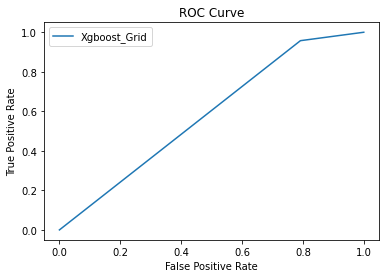

AUC(Xgboost)= 0.68


In [81]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_grid)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost_Grid')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = optimal_params.predict_proba(X_test)
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

In [82]:
models['XGB_best'] = [precision_score(y_test, y_pred_xgb_grid),
                    fbeta_score(y_test, y_pred_xgb_grid, beta=0.5),
                    roc_auc_score(y_test, y_pred_xgb_prob[:,1]),
                    accuracy_score(y_test, y_pred_xgb_grid)]

# SVM Classifier

## Simple Model

In [83]:
svc_model = SVC(C=1, kernel='rbf', probability=True, random_state=rs)
svc = svc_model.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [84]:
print(classification_report(y_test, y_pred_svc))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.66      0.15      0.24       442
         1.0       0.70      0.96      0.81       915

    accuracy                           0.70      1357
   macro avg       0.68      0.56      0.53      1357
weighted avg       0.69      0.70      0.63      1357

F-Beta-Score(0.5) =  0.74


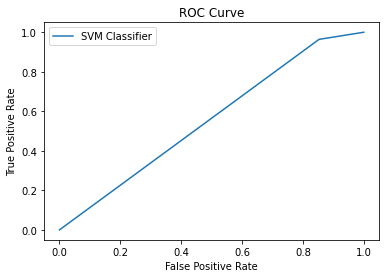

AUC (SVC)= 0.68


In [85]:
# Plot the ROC curve
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_svc)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_svc, tpr_svc, linestyle='-', label='SVM Classifier') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_svc_prob = svc.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC (SVC)= {roc_auc_score(y_test, y_pred_svc_prob[:,1]):.2f}")

In [86]:
models['SVC_simple'] = [precision_score(y_test, y_pred_svc),
                    fbeta_score(y_test, y_pred_svc, beta=0.5),
                    roc_auc_score(y_test, y_pred_svc_prob[:,1]),
                    accuracy_score(y_test, y_pred_svc)]

## Tuning with Gridsearch

In [87]:
grid_svc = {'C': [0.1,1, 10, 50, 100],
             #'kernel': ['linear', 'rbf', 'poly','sigmoid'],
             'kernel': ['linear', 'rbf'],
             'gamma' : [1, 0.1, 0.01, 0.001]
             }

In [88]:
svc_grid = GridSearchCV(estimator= SVC(), 
                        param_grid=grid_svc, 
                        cv=c, 
                        verbose=2, n_jobs=-1,
                        scoring=fhalf_scorer)

In [89]:
svc_grid.fit(X_train, y_train)
y_pred_svc_grid = svc_grid.predict(X_test)
svc_grid.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 141.2min finished


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [90]:
svc_bestmodel = SVC(C=100, kernel='rbf', probability=True, gamma=0.001, random_state=rs)
svc_best = svc_bestmodel.fit(X_train, y_train)
y_pred_svc_best = svc_best.predict(X_test)

In [91]:
print(classification_report(y_test, y_pred_svc_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.62      0.24      0.35       442
         1.0       0.72      0.93      0.81       915

    accuracy                           0.71      1357
   macro avg       0.67      0.59      0.58      1357
weighted avg       0.69      0.71      0.66      1357

F-Beta-Score(0.5) =  0.75


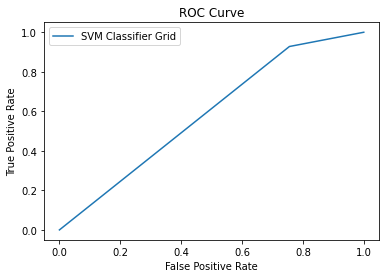

AUC (SVC)= 0.68
AUC (SVC_best)= 0.67


In [92]:
# Plot the ROC curve
fpr_svc_grid, tpr_svc_grid, thresholds_svc_grid = roc_curve(y_test, y_pred_svc_best)
#plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_svc_grid, tpr_svc_grid, linestyle='-', label='SVM Classifier Grid') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_svc_prob_best = svc_best.predict_proba(X_test)
#print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC (SVC)= {roc_auc_score(y_test, y_pred_svc_prob[:,1]):.2f}")
print(f"AUC (SVC_best)= {roc_auc_score(y_test, y_pred_svc_prob_best[:,1]):.2f}")

In [93]:
models['SVC_grid'] = [precision_score(y_test, y_pred_svc_best),
                    fbeta_score(y_test, y_pred_svc_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_svc_prob_best[:,1]),
                    accuracy_score(y_test, y_pred_svc_best)]

# kNN

## Simple kNN

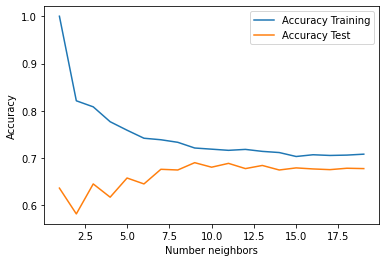

In [94]:
train_accuracy = []
test_accuracy = []
train_beta = []
test_beta = []

# Probiere Werte für k von 1 bis 10 aus
neighbor_settings = range(1, 20)

for k in neighbor_settings:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_beta.append(fbeta_score(y_test, y_pred, beta=0.5))
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbor_settings, train_accuracy, label='Accuracy Training')
plt.plot(neighbor_settings, test_accuracy, label='Accuracy Test')
plt.ylabel('Accuracy')
plt.xlabel('Number neighbors')
plt.legend();

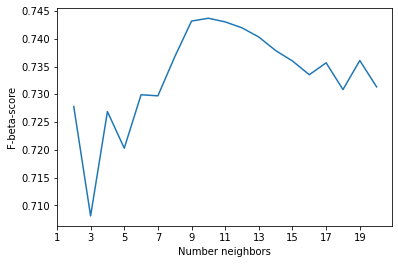

In [95]:
plt.plot(neighbor_settings, train_beta)
plt.ylabel('F-beta-score')
plt.xlabel('Number neighbors')
plt.xticks(ticks=list(range(0,20,2)) ,labels=list(range(1,20,2)));

We take 12 neighbours as best value, for the first simple model.

In [96]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)
y_pred_knn= knn.predict(X_test)

In [97]:
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_knn, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.51      0.27      0.35       442
         1.0       0.71      0.87      0.79       915

    accuracy                           0.68      1357
   macro avg       0.61      0.57      0.57      1357
weighted avg       0.65      0.68      0.65      1357

[[120 322]
 [115 800]]
F-Beta-Score(0.5) =  0.74


In [98]:
y_pred_knn_prob = clf.predict_proba(X_test)


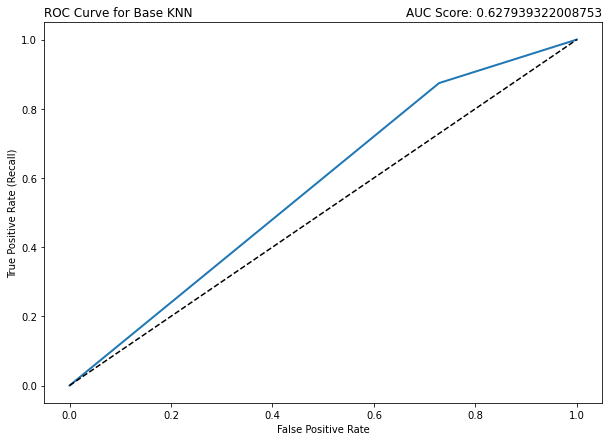

In [99]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
auc_score = roc_auc_score(y_test, y_pred_knn_prob[:,1])

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Base KNN', loc='left')
plt.title(f'AUC Score: {auc_score}', loc='right');

In [100]:
models['knn_simple'] = [precision_score(y_test, y_pred_knn),
                    fbeta_score(y_test, y_pred_knn, beta=0.5),
                    roc_auc_score(y_test, y_pred_knn_prob[:,1]),
                    accuracy_score(y_test, y_pred_knn)]

## Optimize Model

In [101]:
grid_knn = {'n_neighbors' : list(range(1,30)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,20)),
             'metric' : ['euclidean','minkowski','manhattan']}

In [102]:
knn_grid_mod = GridSearchCV(KNeighborsClassifier(), 
                        param_grid=grid_knn, 
                        cv=c, 
                        verbose=False, n_jobs=-1,
                        scoring=fhalf_scorer)
knn_grid_mod.fit(X_train, y_train)
y_pred = knn_grid_mod.predict(X_test)


In [103]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.60      0.15      0.24       442
         1.0       0.70      0.95      0.81       915

    accuracy                           0.69      1357
   macro avg       0.65      0.55      0.52      1357
weighted avg       0.67      0.69      0.62      1357

[[ 68 374]
 [ 46 869]]
F-Beta-Score(0.5) =  0.74


In [104]:
knn_grid_mod.best_params_

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 28,
 'weights': 'uniform'}

In [105]:
y_pred_prob = knn_grid_mod.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}')

ROC-AUC-Score = 0.63


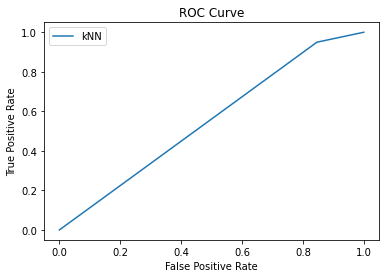

AUC(kNN)= 0.63


In [106]:
# Plot the ROC curve
fpr_knn_grid, tpr_knn_grid, thresholds_grid= roc_curve(y_test, y_pred)
plt.plot(fpr_knn_grid, tpr_knn_grid, linestyle='-', label='kNN') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_prob =knn_grid_mod.predict_proba(X_test)
print(f"AUC(kNN)= {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}")

Confusion matrix, without normalization
[[ 68 374]
 [ 46 869]]


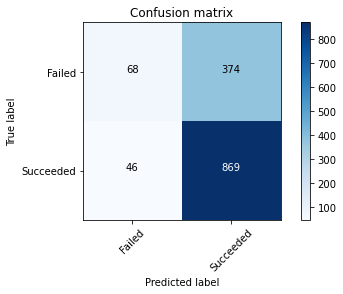

In [107]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [108]:
models['knn_best'] = [precision_score(y_test, y_pred),
                    fbeta_score(y_test, y_pred, beta=0.5),
                    roc_auc_score(y_test, y_pred_prob[:,1]),
                    accuracy_score(y_test, y_pred)]

# Naive Bayes

## Hyperparameter by default

In [109]:
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

In [110]:
print(classification_report(y_test, y_pred_gnb))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.37      0.74      0.50       442
         1.0       0.76      0.41      0.53       915

    accuracy                           0.51      1357
   macro avg       0.57      0.57      0.51      1357
weighted avg       0.64      0.51      0.52      1357

F-Beta-Score(0.5) =  0.65


Confusion matrix, without normalization
[[326 116]
 [544 371]]


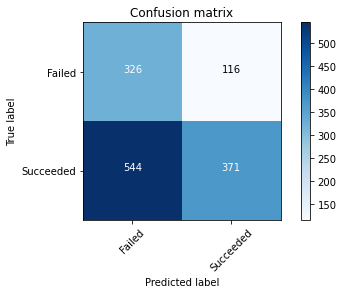

In [111]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

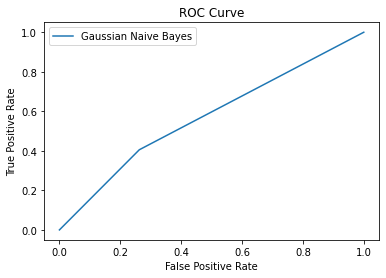

AUC(GNB)= 0.63


In [112]:
# Plot the ROC curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_gnb)
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Gaussian Naive Bayes') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_prob = gnb.predict_proba(X_test)
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")

In [113]:
models['GNB_simple'] = [precision_score(y_test, y_pred_gnb),
                    fbeta_score(y_test, y_pred_gnb, beta=0.5),
                    roc_auc_score(y_test, y_pred_gnb_prob[:,1]),
                    accuracy_score(y_test, y_pred_gnb)]

## Hyperparameter tuning

In [114]:
# Hyperparameter grid for GridSearch for Naive Bayes
params_grid = {'var_smoothing': np.logspace(1,-9, num=1000)}

# Estimator for use in gridSearch
estimator = GaussianNB()

# Create the gridSearch model
gnb_gs = GridSearchCV(estimator, params_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
gnb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    5.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+01, 9.77214697e+00, 9.54948564e+00, 9.33189772e+00,
       9.11926760e+00, 8.91148232e+00, 8.70843150e+00, 8.51000725e+00,
       8.31610415e+00, 8.12661920e+00, 7.94145172e+00, 7.76050334e+00,
       7.58367791e+00, 7.41088152e...
       1.54949504e-09, 1.51418933e-09, 1.47968806e-09, 1.44597292e-09,
       1.41302599e-09, 1.38082977e-09, 1.34936714e-09, 1.31862140e-09,
       1.28857621e-09, 1.25921561e-09, 1.23052400e-09, 1.20248614e-09,
       1.17508713e-09, 1.14831241e-09, 1.12214777e-09, 1.09657929e-09,
       1.07159340e-09, 1.04717682e-09, 1.02331658e-09, 1.00000000e-09])},
             scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [115]:
gnb_gs.best_params_

{'var_smoothing': 3.6271002523306466}

In [116]:
best_model_gnb_gs = gnb_gs.best_estimator_

In [117]:
y_pred_gnb_best = best_model_gnb_gs.predict(X_test)
print(classification_report(y_test, y_pred_gnb_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb_best, beta=0.5 ):.2f}')

              precision    recall  f1-score   support

         0.0       0.50      0.02      0.04       442
         1.0       0.68      0.99      0.80       915

    accuracy                           0.67      1357
   macro avg       0.59      0.51      0.42      1357
weighted avg       0.62      0.67      0.56      1357

F-Beta-Score(0.5) =  0.72


Confusion matrix, without normalization
[[ 10 432]
 [ 10 905]]


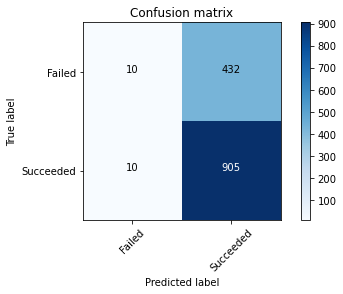

In [118]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

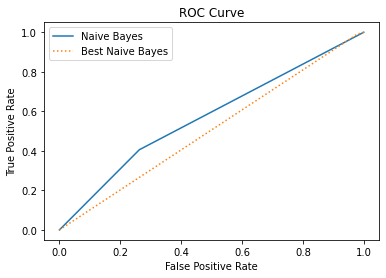

AUC(GNB)= 0.63
AUC(BestGNB)= 0.66


In [119]:
# Plot the ROC curve
fpr_gnb_best, tpr_gnb_best, thresholds_gnb_best = roc_curve(y_test, y_pred_gnb_best)
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Naive Bayes') 
plt.plot(fpr_gnb_best, tpr_gnb_best, linestyle=':', label='Best Naive Bayes')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_best_prob = best_model_gnb_gs.predict_proba(X_test)
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")
print(f"AUC(BestGNB)= {roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]):.2f}")

In [120]:
models['GNB_best'] = [precision_score(y_test, y_pred_gnb_best),
                    fbeta_score(y_test, y_pred_gnb_best, beta=0.5),
                    roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]),
                    accuracy_score(y_test, y_pred_gnb_best)]

# Overview

**Comparison of the results**

In [121]:
overview = pd.DataFrame.from_dict(models, orient='index')
overview.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
overview.sort_values(by='F-Beta(0.5)', ascending=False)

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
Ada_best,0.725724,0.759223,0.669048,0.716286
XGB_simple,0.718519,0.755844,0.694141,0.717023
XGB_best,0.714519,0.752707,0.679168,0.713338
Ada_simple,0.721739,0.752493,0.663808,0.701548
RF_best,0.712560,0.752167,0.682803,0.714812
SVC_grid,0.717667,0.751727,0.667349,0.705232
logReg_best,0.708543,0.743279,0.669434,0.692704
RF_simple,0.703050,0.742499,0.666121,0.698600
logReg_simple,0.707705,0.742400,0.669710,0.691231
SVC_simple,0.700556,0.741052,0.675185,0.697863


It appears that for XGBoost and knn the grid search parameters have not led to an improvement of the base model performance. Removing the tracheo column has deteriorated the performance of the models.

In [122]:
bestmodels = overview.drop(['logReg_simple', 'RF_simple', 'Ada_simple', 'XGB_simple',
                            'SVC_simple', 'knn_simple', 'GNB_simple'],axis=0)

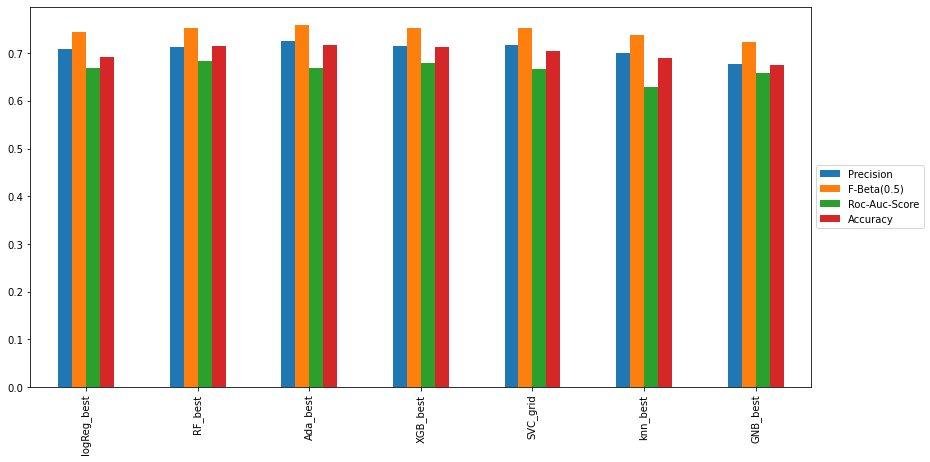

In [123]:
bestmodels.plot(kind='bar', figsize=(14,7))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

**XGBoost and AdaBoost show the best performance with regard to all evaluation metrics.**

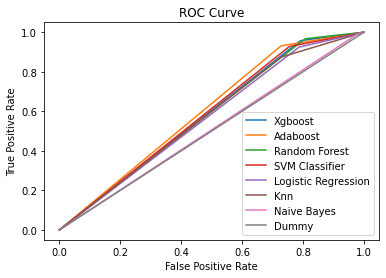

AUC(Xgboost)= 0.68
AUC(Adaboost)= 0.67
AUC(Random Forest)= 0.68
AUC (SVM Classifier)= 0.67
AUC(Logistic Regression)= 0.67
AUC(Knn)= 0.63
AUC(Naive Bayes)= 0.66
AUC(Dummy)= 0.49


In [129]:
# Plot the ROC curve
plt.plot(fpr_xgb, tpr_xgb, label='Xgboost')
plt.plot(fpr_ada, tpr_ada, label='Adaboost')
plt.plot(fpr_rf_gs, tpr_rf_gs, label='Random Forest')
plt.plot(fpr_svc_grid, tpr_svc_grid, label='SVM Classifier')
plt.plot(fpr_lr_best, tpr_lr_best, label='Logistic Regression')
plt.plot(fpr, tpr, label='Knn')
plt.plot(fpr_gnb_best, tpr_gnb_best, label='Naive Bayes')
plt.plot([0, 1], [0, 1], label = 'Dummy') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")
print(f"AUC(Random Forest)= {roc_auc_score(y_test, y_proba_rf_adv[:,1]):.2f}")
print(f"AUC (SVM Classifier)= {roc_auc_score(y_test, y_pred_svc_prob_best[:,1]):.2f}")
print(f"AUC(Logistic Regression)= {roc_auc_score(y_test, y_pred_lr_best_prob[:,1]):.2f}")
print(f"AUC(Knn)= {roc_auc_score(y_test, y_pred_knn_prob[:,1]):.2f}")
print(f"AUC(Naive Bayes)= {roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]):.2f}")
print("AUC(Dummy)= 0.49")

# Feature Importance

##### Set the color palette

In [124]:
# Explore color codes
blue_1 = '#4fbbd2'
blue_2 = '#0085a0'
blue_3 = '#173f6d'
green = '#21a8a4'
red = '#f27050'
orange = '#ffa733'

# List of colors 
colors = [blue_3, blue_2, blue_1, green, orange, red]
current_palette = sns.color_palette(colors)

##### Initialize our best fitted Classifiers 

In [125]:
ABC = ada.feature_importances_
XGBC = xgboost.feature_importances_
RDMC = best_model_rf_adv.feature_importances_
LOGC = abs(best_model_lr_gs.coef_[0])


# List of Tree-based Classifiers used for feature Selection
best_clf = [ABC, XGBC, RDMC, LOGC]

# List of Classifier Names
name_clf = ["ABC", "XGBC", "RDMC", "LOGC"]

##### make a function that gives us only the first 25 best features

In [126]:
def feature_selection(results_dict, tree_clf, name_clf, n=25):
    
    # n is the number of Features + classifier added to the results dictionary (default=20)
    # and printed during process for each classifier
    # if n=None all Features + classifier are added and printed
    
    count = 0
    
    for classifier in tree_clf:
        
        indices = np.argsort(classifier)[::-1]
        feature_name = X.columns[indices]
    
        # Write first n Ranks to dictionary results_dict as 
        # "name_clf: (feature_name, importance)", default is n=20
        results_dict[name_clf[count]] = list(zip(feature_name[0:n], classifier[indices][0:n]))     
        
        count +=1
    
        
    return results_dict

##### Create dataframes for visualization

In [127]:
# Create Dictionary for Feature Selection Results
results_fs = {}

# Use feature_selection function 
feature_selection(results_fs, best_clf, name_clf)

# Making Dataframes from results_fs Dictionary
log_dataframe = pd.DataFrame(results_fs["LOGC"]).rename(columns={0:"Features", 1:"importance value"})
rfc_dataframe = pd.DataFrame(results_fs["RDMC"]).rename(columns={0:"Features", 1:"importance value"})
abc_dataframe = pd.DataFrame(results_fs["ABC"]).rename(columns={0:"Features", 1:"importance value"})
xgbc_dataframe = pd.DataFrame(results_fs["XGBC"]).rename(columns={0:"Features", 1:"importance value"})

##### make the visualization

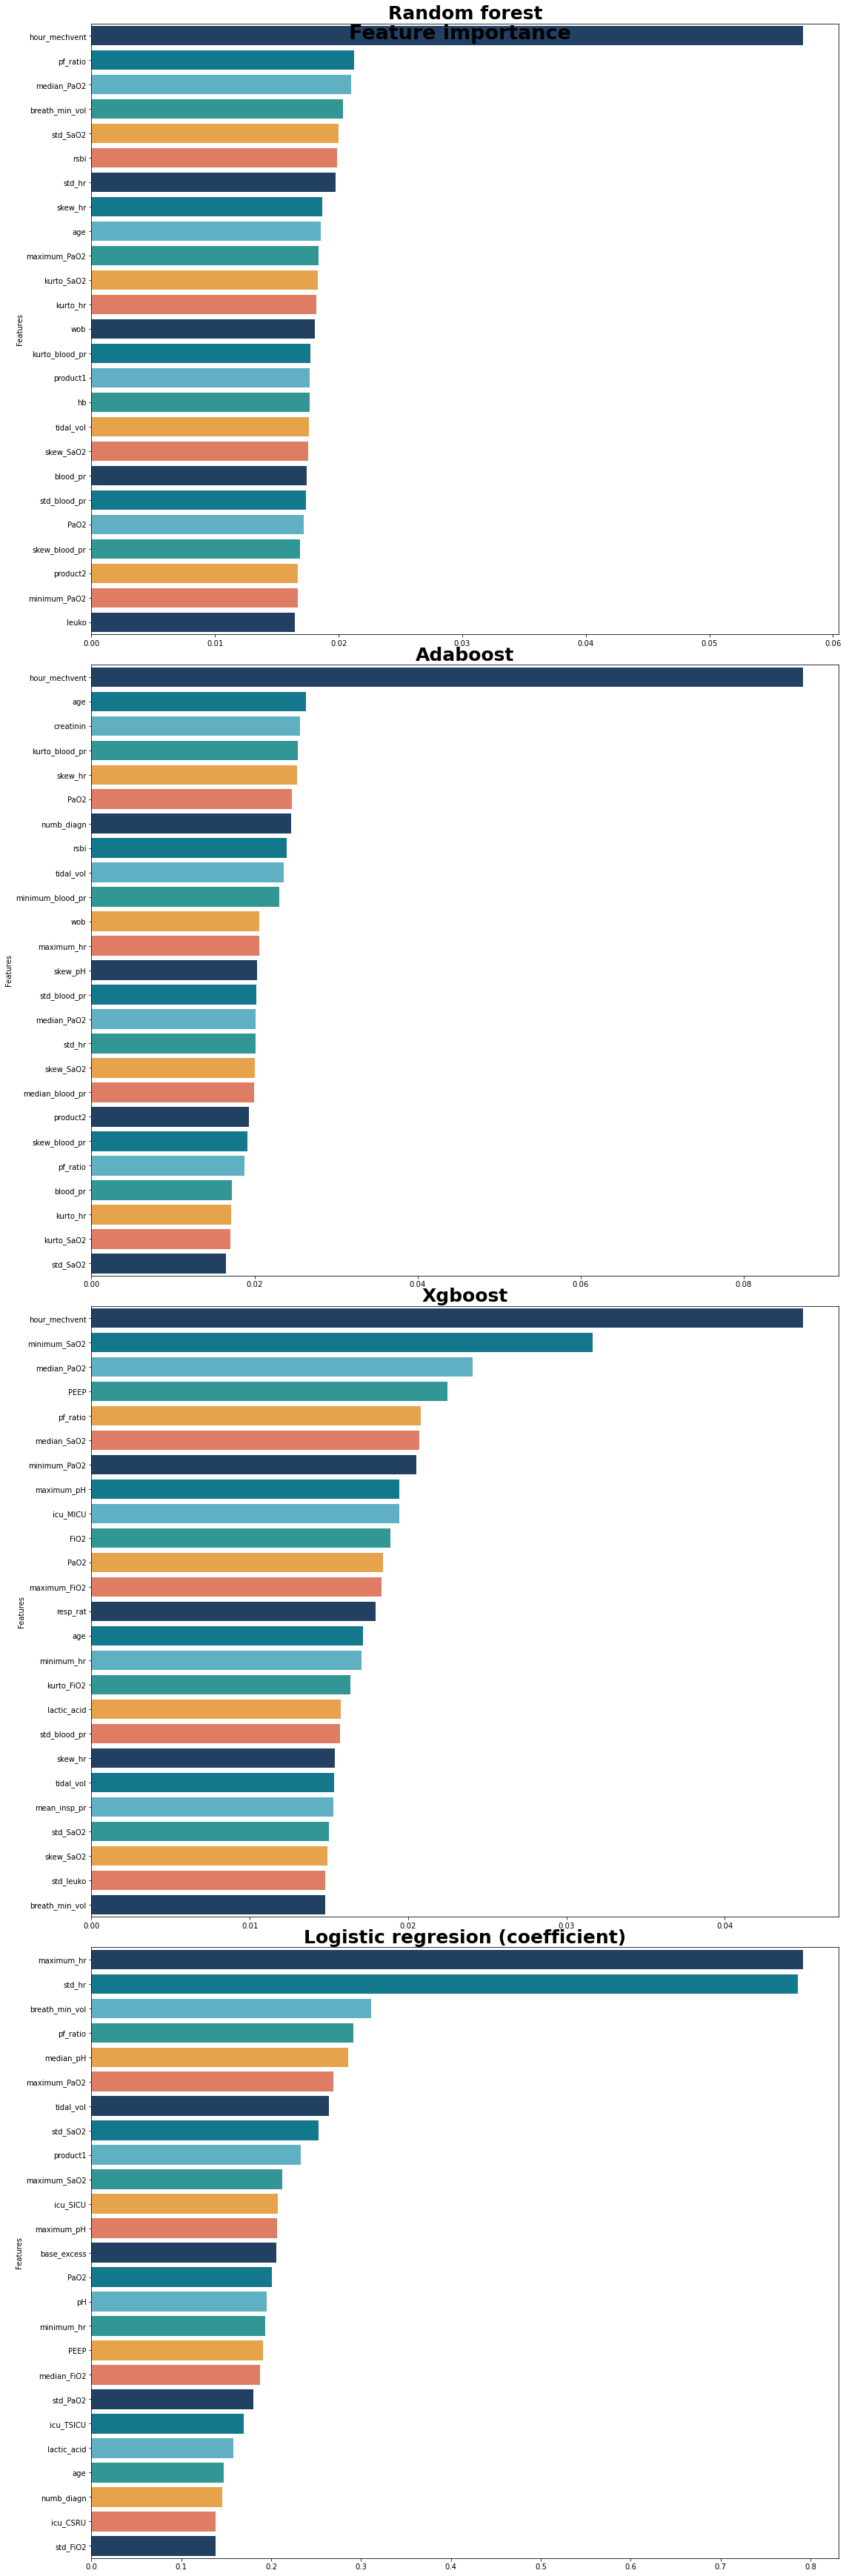

In [130]:
# Plots for feature Selection
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 49))
f.suptitle("Feature importance",fontsize=27, fontweight = 'bold', y= 0.98)
f.tight_layout(pad=2.0)
sns.set_context("poster")

sns.barplot(y="Features", x="importance value", data=rfc_dataframe, ax=ax1, palette=current_palette)
sns.barplot(y="Features", x="importance value", data=abc_dataframe, ax=ax2, palette=current_palette)
sns.barplot(y="Features", x="importance value", data=xgbc_dataframe, ax=ax3, palette=current_palette) 
sns.barplot(y="Features", x="importance value", data=log_dataframe, ax=ax4, palette=current_palette)

ax1.set_title("Random forest", fontsize=25, fontweight="bold")
ax2.set_title("Adaboost", fontsize=25, fontweight="bold")
ax3.set_title("Xgboost", fontsize=25, fontweight="bold")
ax4.set_title("Logistic regresion (coefficient)", fontsize=25, fontweight="bold")

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('');

The removal of the tracheo column did not produce any significant shift in the feature importance.

# Best Models with only the most important features

In order to check whether the reduction of the dimension improves the model or whether a lower number of features is sufficient, we now examine the performance of the model with a reduced number of features. For this we vary the number of features (according to the importance in the respective model) and evaluate the model.

In [131]:
def feature_redu (dataframe, number_features, estimator):
    liste = list(dataframe.Features.loc[:(number_features-1)].values)
    X1 = df[liste]
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.25, random_state=rs, stratify=y)
    scaler = preprocessing.StandardScaler().fit(X_train1)
    X_train1 = scaler.transform(X_train1)
    X_test1 = scaler.transform(X_test1)
    
    clf_reduced = estimator
    clf_reduced.fit(X_train1, y_train1)
    y_pred_clf_reduced = clf_reduced.predict(X_test1)
    #print(classification_report(y_test1, y_pred_clf_reduced))
    #print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test1, y_pred_clf_reduced, beta=0.5 ):.2f}')
    y_pred_clf_prob_reduced = clf_reduced.predict_proba(X_test1)
    #print(f"AUC= {roc_auc_score(y_test1, y_pred_clf_prob_reduced[:,1]):.2f}")
    
    return [precision_score(y_test1, y_pred_clf_reduced),
            fbeta_score(y_test1, y_pred_clf_reduced, beta=0.5),
            roc_auc_score(y_test1, y_pred_clf_prob_reduced[:,1]),
            accuracy_score(y_test1, y_pred_clf_reduced)]
    

In [132]:
def first_feature (diction, dataframe, number, estimator):
    
    for i in range(number):
        diction[i+1] = feature_redu(dataframe, i+1, estimator)
    ubersicht = pd.DataFrame.from_dict(diction, orient='index')
    ubersicht.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
    return ubersicht.sort_values(by='F-Beta(0.5)', ascending = False)
    

In [133]:
xgb = {}
ubersicht_xgb = first_feature(xgb, xgbc_dataframe, 20, XGBClassifier())
ubersicht_xgb.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
8,0.718928,0.757835,0.653575,0.722918
15,0.719934,0.757234,0.687620,0.719234
14,0.719703,0.756893,0.688513,0.718497
16,0.717801,0.755483,0.683175,0.717023
12,0.717928,0.755321,0.675057,0.716286


In [134]:
ada = {}
ubersicht_ada = first_feature(ada, abc_dataframe, 20, AdaBoostClassifier())
ubersicht_ada.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
10,0.711297,0.746269,0.651176,0.697863
13,0.710460,0.745391,0.666730,0.696389
8,0.711036,0.745188,0.639615,0.694915
18,0.711375,0.744624,0.643878,0.692704
19,0.710034,0.743015,0.648907,0.689757


In [135]:
logReg = {}
ubersicht_logReg = first_feature(logReg, log_dataframe, 20, LogisticRegression(penalty= 'l2', C= 0.1))
ubersicht_logReg.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
16,0.690383,0.732051,0.633398,0.684598
17,0.690307,0.731097,0.647234,0.681651
15,0.686335,0.728531,0.627812,0.679440
20,0.687451,0.727896,0.651398,0.675755
18,0.687451,0.727896,0.648340,0.675755


In [136]:
RF = {}
ubersicht_RF = first_feature(RF, rfc_dataframe, 20, RandomForestClassifier(bootstrap= False, max_depth= 40, max_features= 'auto', min_samples_leaf= 2,
                                     min_samples_split= 7, n_estimators= 500, random_state=rs))
ubersicht_RF.head()

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
14,0.713696,0.750477,0.651634,0.707443
15,0.712183,0.749957,0.653244,0.708180
7,0.714165,0.748365,0.617928,0.700074
20,0.709388,0.747206,0.654923,0.703758
11,0.710265,0.746476,0.641228,0.700074


In [137]:
best_model= pd.concat([ubersicht_ada.iloc[:1,:], ubersicht_xgb.iloc[:1,:], ubersicht_RF.iloc[:1,:],
                       ubersicht_logReg.iloc[:1,:]])
best_model.reset_index(inplace=True)
best_model.rename(columns={'index':"Number_features"},inplace=True)
metrics=  pd.DataFrame({'Metrics': ['Adaboost','Xgboost', 'Random_forest', 'Logistic_regresion']})
best_model= pd.concat([best_model,metrics], axis=1)
best_model.set_index('Metrics')
best_model.sort_values(by='F-Beta(0.5)', ascending=False)

,Number_features,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy,Metrics
1,8,0.718928,0.757835,0.653575,0.722918,Xgboost
2,14,0.713696,0.750477,0.651634,0.707443,Random_forest
0,10,0.711297,0.746269,0.651176,0.697863,Adaboost
3,16,0.690383,0.732051,0.633398,0.684598,Logistic_regresion


In [138]:
best_features = pd.concat([pd.DataFrame({'Adaboost':abc_dataframe.iloc[:best_model.iloc[0,0],0].values}),
                              pd.DataFrame({'Xgboost':xgbc_dataframe.iloc[:best_model.iloc[1,0],0].values}),
                              pd.DataFrame({'Random_forest':rfc_dataframe.iloc[:best_model.iloc[2,0],0].values}),
                              pd.DataFrame({'Logistic_regresion':log_dataframe.iloc[:best_model.iloc[3,0],0].values})],
                               axis=1)
best_features

,Adaboost,Xgboost,Random_forest,Logistic_regresion
0,hour_mechvent,hour_mechvent,hour_mechvent,maximum_hr
1,age,minimum_SaO2,pf_ratio,std_hr
2,creatinin,median_PaO2,median_PaO2,breath_min_vol
3,kurto_blood_pr,PEEP,breath_min_vol,pf_ratio
4,skew_hr,pf_ratio,std_SaO2,median_pH
5,PaO2,median_SaO2,rsbi,maximum_PaO2
6,numb_diagn,minimum_PaO2,std_hr,tidal_vol
7,rsbi,maximum_pH,skew_hr,std_SaO2
8,tidal_vol,NaN,age,product1
9,minimum_blood_pr,NaN,maximum_PaO2,maximum_SaO2


# Conclusion

Removing the tracheo column has worsened the performance of the models, but has hardly affected the importance of the remaining features.   
The dominance of the "tracheo" feature does not hide the influence of the other features.